# Estimation of a Gaussian Mixture Model with Gradient Descent on the NLL

In [1]:
%matplotlib inline
from math import sqrt
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
try:
    sess.close()
except NameError:
    pass
sess = tf.InteractiveSession()

/home/ogrisel/code/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Parameterization of a covariance matrix

Parameterize a covariance matrix as the sum of a full rank positive diagonal with low rank symmetric and positive semidefinite matrix d and W can take arbitrary components values, C is guaranteed to always be symmetric and positive definite thanks to the parameterization.

In [70]:
batch_size = 10
n_features = 2
cov_rank = 1
init_seed = 1

X = tf.placeholder(shape=(batch_size, n_features), dtype=tf.float32, name='X')


with tf.variable_scope('covariance'):
    d = tf.Variable(tf.truncated_normal(shape=(n_features,),
                                        stddev=1 / sqrt(n_features),
                                        dtype=tf.float32,
                                        seed=init_seed),
                    name='d')
    W = tf.Variable(tf.truncated_normal(shape=(n_features, cov_rank),
                                        stddev=1 / sqrt(n_features),
                                        dtype=tf.float32,
                                        seed=init_seed),
                    name='W')

    C = tf.add(tf.diag(tf.exp(d)), tf.matmul(W, tf.transpose(W)), name='C')

sess.run(tf.initialize_all_variables())

In [3]:
C.eval()

array([[ 0.89256191, -0.60224104],
       [-0.60224104,  3.9590106 ]], dtype=float32)

In [4]:
tf.matrix_determinant(C).eval()

3.1709678

## Optimization of a loss function that depends on the determinant w.r.t. of C

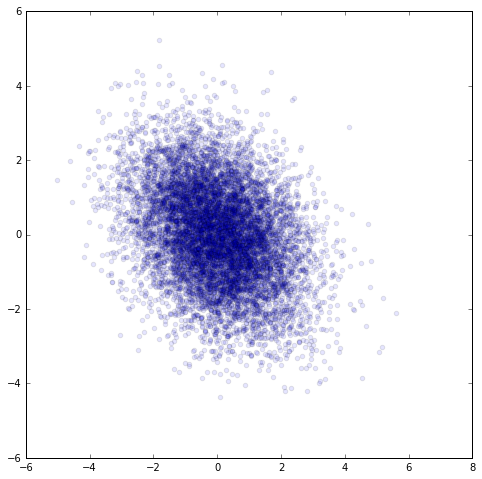

In [57]:
sess.run(tf.initialize_all_variables())
rng = np.random.RandomState(42)
samples = rng.multivariate_normal(np.zeros(n_features), C.eval(), size=10000)
plt.figure(figsize=(8, 8))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1);

In [58]:
det = tf.matrix_determinant(C)
loss = (det - 42) ** 2
optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(loss)
sess.run(tf.initialize_all_variables())

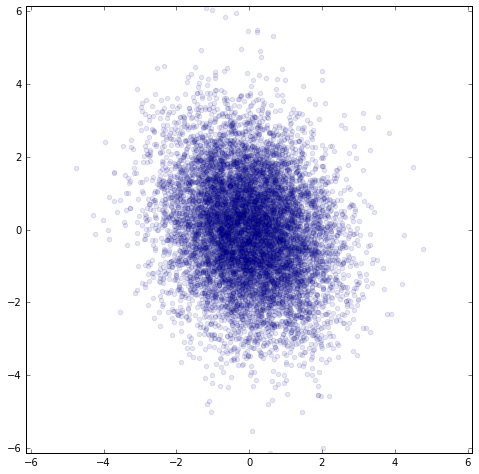

In [59]:
samples = np.random.multivariate_normal(np.zeros(n_features), C.eval(), size=10000)
max_abs = np.abs(samples).max()
plt.figure(figsize=(8, 8))
plt.xlim(-max_abs, max_abs)
plt.ylim(-max_abs, max_abs)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1);

In [60]:
C.eval()

array([[ 1.33628297, -0.33483538],
       [-0.33483538,  2.1334796 ]], dtype=float32)

In [61]:
losses, determinants = [], []
losses.append(loss.eval())
determinants.append(det.eval())
for i in range(1000):
    train_op.run()
    losses.append(loss.eval())
    determinants.append(det.eval())

In [62]:
losses[0], losses[-1]

(1541.4403, 0.0)

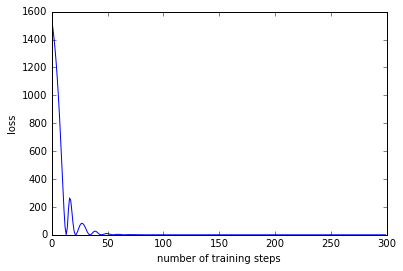

In [63]:
plt.plot(losses[:300])
plt.ylabel('loss'),
plt.xlabel('number of training steps');

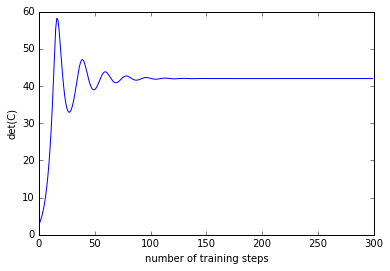

In [64]:
plt.plot(determinants[:300])
plt.ylabel('det(C)'),
plt.xlabel('number of training steps');

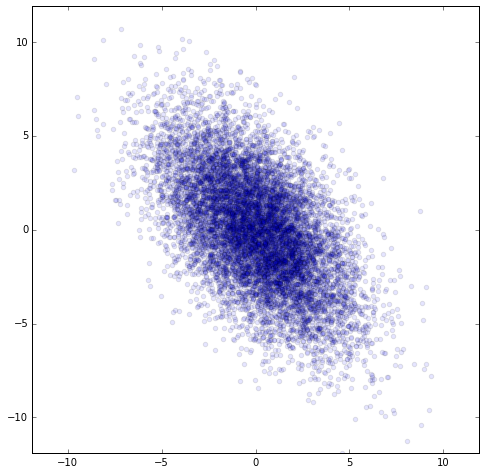

In [65]:
samples = np.random.multivariate_normal(np.zeros(n_features), C.eval(), size=10000)
max_abs = np.abs(samples).max()
plt.figure(figsize=(8, 8))
plt.xlim(-max_abs, max_abs)
plt.ylim(-max_abs, max_abs)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1);

In [66]:
C.eval()

array([[ 6.78972816, -4.32486677],
       [-4.32486677,  8.94063377]], dtype=float32)

In [67]:
tf.matrix_determinant(C).eval()

42.0

## Evaluation of the density

In [68]:
X_data = rng.randn(batch_size, n_features)
X_data

array([[ 0.34828625,  0.28332359],
       [-0.93651985,  0.57958422],
       [-1.49008268, -0.65418433],
       [-1.99908781,  1.55862652],
       [-0.23154949,  2.16688403],
       [ 0.80294993,  0.44809821],
       [-0.58622769, -1.04635004],
       [ 0.52297157, -0.07151401],
       [-1.33927032, -1.51685842],
       [-0.95870373,  1.82096723]])

In [69]:
sess.run(tf.reduce_sum(tf.mul(X, tf.matmul(X, C)), reduction_indices=1),
         feed_dict={X: X_data})

array([  0.68776548,  13.65338898,  10.47009277,  75.80488586,
        46.6836853 ,   3.0605619 ,   6.81627464,   2.22620845,
        15.1777153 ,  50.98740005], dtype=float32)